In [1]:
import os

os.chdir("../..")

In [2]:

from datetime import datetime, timezone
from typing import Dict, List, Literal, cast
import os 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI as LangchainChatOpenAI
# from langchain_core.messages import HumanMessage, SystemMessage, MessagesPlaceholder
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from src.react_agent.configuration import Configuration
from src.react_agent.state import InputState, OverallState, OutputState
from src.react_agent.tools import TOOLS
from src.react_agent.utils import load_chat_model
from typing import Any, List, Optional, Union
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from dataclasses import dataclass, field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI as LangchainChatDeepSeek
from langchain_core.prompts import MessagesPlaceholder
from langchain.schema import HumanMessage, SystemMessage, AIMessage  # Import AIMessage for assistant responses
from langgraph.checkpoint.memory import MemorySaver

import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
# Suppress debug messages from the comm module
logging.getLogger('comm').setLevel(logging.WARNING)
# Define the state object
# state = OverallState()

from src.react_agent.agent import ( travel_itinerary_planner, flight_finder_tool_node,
                                accommodation_finder_node, activities_node, ticketmaster_node, recommendations_node, airbnb_node,
                                accomodation_router, accomodation_router_2, recommendations_node_2, recommendation_router)

from src.react_agent.tools import (TOOLS, amadeus_tool, amadeus_hotel_tool, geoapify_tool, weather_tool,  AmadeusFlightSearchInput,
                                   FlightSearchInput,
                                   googlemaps_tool, flight_tool, google_scholar_tool, booking_tool, tavily_search_tool,
                                   flight_tools_condition, accomodation_tools_condition, activity_planner_tools_condition,
                                   multiply_tool, GoogleMapsPlacesInput, google_places_tool, google_find_place_tool, google_place_details_tool,
                                   google_events_tool, GoogleEventsSearchInput, TicketmasterEventSearchInput, ticketmaster_tool)

from src.react_agent.pretty_print import pretty_print_output
from src.react_agent.graph import graph

from langchain.agents import create_react_agent, AgentExecutor
from src.react_agent.prompts import SYSTEM_PROMPT, FLIGHT_FINDER_PROMPT, ACTIVITY_PLANNER_PROMPT, RECOMMENDATION_PROMPT
from langchain.tools import BaseTool, Tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.prebuilt import tools_condition
from dotenv import load_dotenv

from datetime import date
import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
logging.getLogger('comm').setLevel(logging.WARNING)
logging.getLogger('tornado').setLevel(logging.WARNING)
logging.getLogger('traitlets').setLevel(logging.WARNING)

# Disable all logging globally
logging.disable(logging.CRITICAL)  # Disable all logging below CRITICAL level

# Redirect all logging output to os.devnull
logging.basicConfig(level=logging.CRITICAL, handlers=[logging.NullHandler()])

# Suppress warnings as well (optional)
import warnings
warnings.filterwarnings("ignore")

# Load environment variables from the .env file
load_dotenv()

INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60


✅ API keys validated.


DEBUG:pydot:pydot initializing
DEBUG:pydot:pydot 3.0.4
DEBUG:pydot.dot_parser:pydot dot_parser module initializing
DEBUG:pydot.core:pydot core module initializing
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'


True

In [3]:
llm = LangchainChatDeepSeek(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    model= "deepseek-chat",
    base_url="https://api.deepseek.com",
)

user_input = """
So I intend to visit a few states in the USA. I don't know which one I would start with but let's say I go to New York City because my friend 
lives in New York and I go to see him. I live in Oklahoma right now and so let's say I decide to go towards the middle of February 
to New York City to see him and I would probably like to go after Valentine's because he might have plans and let's say I go after Valentine's 
to see him in New York City. Just to give you some perspective, the year is 2025 and we are currently in January. January 27th is today but I 
intend to go next month. I don't really know some exciting things that they do in New York City so I don't really know what to expect. 
But I'm flexible to a lot of things. I'm flexible to partying, to just understanding the culture and what they actually do there. 
I wouldn't be living with him so I might have to rent a hostel or an Airbnb somewhere that is affordable in New York City. 
I think he lives close to the University of New York City so wherever I'm going to rent, it's going to likely be close to the 
University in New York City and I don't really know how cold it gets there so I pretty much need some information about what to do, 
where to stay, how to park because it gets really cold in New York City as I head. So I would like some advice, some itinerary, 
some guide on this entire travel. To come back, I don't really know when I want to come back but I know the maximum I want to spend 
there is like 2 or 3 days. Let's just say it's 3 days or 4 days. That's the maximum I want to spend there. So since I intend to go after 
Valentine's, I would recommend that you just pick a day after Valentine's, maybe a day on the weekend I guess. That would be preferable, 
a day on the weekend after Valentine's and then let's see how we can plan for that time.
"""    



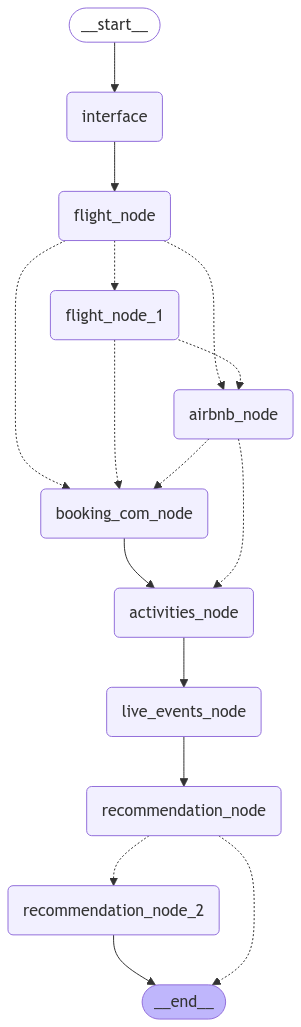

In [4]:

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [5]:
# **Input Collection**
user_input = """
Hi, I want to travel to New York City from Oklahoma and I want to travel tomorrow, which is the 2nd of February, 2025. 
And I'm looking to spend about five or six days during the journey. I want to go to the club. I want to party. I would like to also, 
you know, eat African food, Nigerian food in the restaurants and pretty much see what it's like. So, you know, some other things I want to do, 
but I don't really know yet. I would like some recommendations on what and what I would want to do. So just give me some recommendations. 
Just something like this.

"""

# **Input State**
input_state = {"messages": [HumanMessage(content=user_input)]}

# **Graph Invocation**
output = graph.invoke(input_state, {"recursion_limit": 3000})
# output.get("messages")[-1].content

pretty_print_output(output)


======================== TRIP OVERVIEW ======================

TRIP OVERVIEW
+-------------+---------------+
| Field       | Value         |
+-------------+---------------+
| Location    | Oklahoma      |
| Destination | New York City |
| Start Date  | 2025-02-02    |
| End Date    | 2025-02-07    |
| Budget      |               |
| Adults      | 1             |
| Children    | 0             |
+-------------+---------------+


========================== FLIGHTS ==========================


--- DEPARTURE FLIGHTS (economy Class) ---

+----+----------+-----------------------------+-----------------------------+------------+--------------+-------+-------+---------+
| #  | Airline  | Departure                   | Arrival                     | Route      | Duration     | Stops | Price | Booking |
+----+----------+-----------------------------+-----------------------------+------------+--------------+-------+-------+---------+
| 1  | American | 6:00 AM on Sun, Feb 2, 2025 | 1:30 PM on Sun, F

In [12]:
output['flights']

[{'departure flights': [{'airline': 'American',
    'departure_time': '6:00 AM on Sun, Feb 2, 2025',
    'arrival_time': '1:30 PM on Sun, Feb 2, 2025',
    'departure_airport': 'OKC',
    'arrival_airport': 'JFK',
    'duration': '6 hr 30 min',
    'stops': 1,
    'price': '$410',
    'travel_class': 'economy'},
   {'airline': 'American',
    'departure_time': '6:55 AM on Sun, Feb 2, 2025',
    'arrival_time': '3:00 PM on Sun, Feb 2, 2025',
    'departure_airport': 'OKC',
    'arrival_airport': 'JFK',
    'duration': '7 hr 5 min',
    'stops': 1,
    'price': '$410',
    'travel_class': 'economy'},
   {'airline': 'American',
    'departure_time': '8:47 AM on Sun, Feb 2, 2025',
    'arrival_time': '4:59 PM on Sun, Feb 2, 2025',
    'departure_airport': 'OKC',
    'arrival_airport': 'JFK',
    'duration': '7 hr 12 min',
    'stops': 1,
    'price': '$410',
    'travel_class': 'economy'},
   {'airline': 'American',
    'departure_time': '7:47 AM on Sun, Feb 2, 2025',
    'arrival_time': '